In [1]:
%matplotlib inline
import sys
sys.path.append('/Users/pradap/Documents/Research/Python-Package/anhaid/py_entitymatching/')

![title](workflow.png)

In [2]:
# py_entitymatching relies on the following packages from the Python eco-system

|S.No|  Package | Comments  |
|---|---|---|
|1|  *pandas*  | provides data structures (such as DataFrame) to store and **manage relational data**. Specifically, DataFrame is used to represent input tables.  |
|2| *scikit-learn*   | provides implementations for common **machine learning algorithms**. Specifically, this is used in ML-based matchers.  |
|3| *joblib*  | provides **multiprocessing** capabilities. Specifically, this is used to parallelize blockers across multiple processors.|
|4| *PyQt4*  | provides tools to **build GUI**. Specifically, this is used to build GUI for labeling data  and debugging matchers.|
|5|  *py_stringsimjoin* |  provides **scalable** implementations for **string similarity joins** over two tables. Specifically,   this is used to scale blockers. |
|6| *py_stringmatching* | provides a comprehensive set of **tokenizers and string similarity functions**. Specifically, this is to create features for blocking and matching.|
|7|  *cloudpickle* |provides functions to **serialize Python constructs**. Specifically, this is used to load/save objects from/to disk. |
|8| *pyprind*  | library to display **progress indicators**. Specifically, this is used to display progress of blocking functions, matching functions, etc.  |
|9| *pyparsing*  | library to **parse strings**. Specifically, this is used to parse rules/features that are declaratively written by the user.  |
|10|  *six* |  provides functions to write **compatible code across Python 2 and 3**. |

In [3]:
import py_entitymatching as em
import profiler
import pandas as pd
import qgrid

## Read input tables

In [4]:
## Read input tables
A = em.read_csv_metadata('dblp_demo.csv', key='id')
B = em.read_csv_metadata('acm_demo.csv', key='id')

In [5]:
A.head(2)

id                                                               title  \
0  l0                    Paradise: A Database System for GIS Applications   
1  l1  A Query Language and Optimization Techniques for Unstructured Data   

                                                           authors  \
0                                                    Paradise Team   
1  Gerd G. Hillebrand, Peter Buneman, Susan B. Davidson, Dan Suciu   

               venue  year  
0  SIGMOD Conference  1995  
1  SIGMOD Conference  1996

In [6]:
B.head(2)

id  \
0  r0   
1  r1   

                                                                                    title  \
0                               An efficient bitmap encoding scheme for selection queries   
1  Integrating a Structured-Text Retrieval System with an Object-Oriented Database System   

                               authors  \
0  Chee-Yong Chan, Yannis E. Ioannidis   
1        Tak W. Yan, Jurgen Annevelink   

                                            venue  year  
0  International Conference on Management of Data  1999  
1                           Very Large Data Bases  1994

In [7]:
# If the tables are large we can downsample the tables like this
A1, B1 = em.down_sample(A, B, 500, 1, show_progress=False)
len(A1), len(B1)

# But for the demo, we will use the entire table A and B

(476, 500)

## Block tables to get candidate set

In [8]:
# Explore tables to decide on the blocking attribute
# qgrid.show_grid(A)

In [9]:
# Explore to decide on the blocking attribute
# qgrid.show_grid(B)

In [10]:
profiler.profile_table(A, 'year')

Number of unique values: 10
Number of missing values: 0

Unique values:
[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003]

Frequency plot:



Number of unique values: 11
Number of missing values: 0

Unique values:
[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 20003]

Frequency plot:



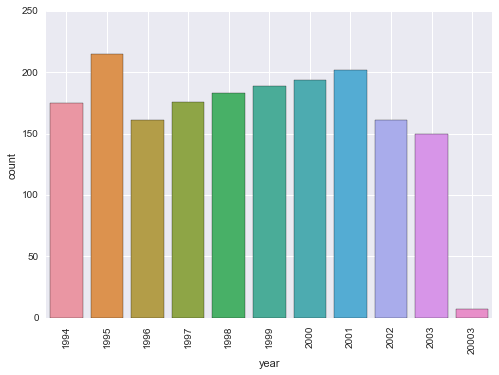

In [11]:
profiler.profile_table(B, 'year')

In [12]:
B.replace({'year':{
            20003:2003
        }}, inplace=True)

![title](profile_table.png)

In [13]:
### Blocking plan

### A, B -- AttrEquivalence blocker [year]--------------------------| Candidate set

In [14]:
# Create attribute equivalence blocker
ab = em.AttrEquivalenceBlocker()
# Block tables using 'year' attribute : same year include in candidate set
C1 = ab.block_tables(A, B, 'year', 'year', 
                     l_output_attrs=['title', 'authors', 'year'],
                     r_output_attrs=['title', 'authors', 'year']
                    )
len(C1)

328781

In [15]:
C1.head(2)

_id ltable_id rtable_id                                      ltable_title  \
0    0        l0        r2  Paradise: A Database System for GIS Applications   
1    1        l0        r3  Paradise: A Database System for GIS Applications   

  ltable_authors  ltable_year  \
0  Paradise Team         1995   
1  Paradise Team         1995   

                                      rtable_title  \
0                         Nearest neighbor queries   
1  The LyriC language: querying constraint objects   

                                        rtable_authors  rtable_year  
0  Nick Roussopoulos, Stephen Kelley, Frédéric Vincent         1995  
1                   Alexander Brodsky, Yoram Kornatzky         1995

### Debug blocking output

In [16]:
# check whether the current blocking method has dropped a lot of potential matches
dbg = em.debug_blocker(C1, A, B, 
                       l_output_attrs=['title', 'authors', 'year'], 
                       r_output_attrs=['title', 'authors', 'year'])

In [17]:
dbg.head()

_id  similarity ltable_id rtable_id  \
0    0    0.941176      l239      r821   
1    1    0.941176      l941       r94   
2    2    0.928571      l790      r106   
3    3    0.928571     l1039     r1051   
4    4    0.923077     l1207      r148   

                                                                                         ltable_title  \
0                       Workshop Report on Experiences Using Object Data Management in the Real-World   
1  Some Remarks on Variable Independence, Closure, and Orthographic Dimension in Constraint Databases   
2                                         Research in database engineering at the University of Namur   
3                           Middle East Technical University Software Research and Development Center   
4                                                                  Database Research at NTHU and ITRI   

      ltable_authors  ltable_year  \
0  Akmal B. Chaudhri         1998   
1      Leonid Libkin         1999   
2   Jean-Luc Hainaut         2003   
3       Asuman Dogac         1996   
4   Arbee L. P. Chen         1994   

                                                                                         rtable_title  \
0                       Workshop report on experiences using object data management in the real-world   
1  Some remarks on variable independence, closure, and orthographic dimension in constraint databases   
2                                         Research in database engineering at the University of Namur   
3                           Middle East Technical University Software Research and Development Center   
4                                                                  Database research at NTHU and ITRI   

      rtable_authors  rtable_year  
0  Akmal B. Chaudhri         1999  
1      Leonid Libkin         1998  
2   Jean-Luc Hainaut         2002  
3       Asuman Dogac         1998  
4   Arbee L. P. Chen         1995

In [18]:
# em.view_table(dbg)

In [19]:
# Revised blocking plan

# A, B -- AttrEquivalence blocker [year] --------------------|
#                                                           |---> candidate set
# A, B -- Overlap blocker [title]---------------------------|

In [20]:
profiler.profile_table(A, 'title', plot=False)

Property  \
0    Num. Missing Values   
1     Num. Unique Values   
2  List of Unique Values   

                                                                                                 Value  
0                                                                                                    0  
1                                                                                                 1797  
2  [1-Safe Algorithms for Symmetric Site Configurations, 3D Geographic Network Displays, 50,000 Use...

In [21]:
profiler.profile_table(B, 'title', plot=False)

Property  \
0    Num. Missing Values   
1     Num. Unique Values   
2  List of Unique Values   

                                                                                                 Value  
0                                                                                                    0  
1                                                                                                 1803  
2  [1-Safe Algorithms for Symmetric Site Configurations, 2Q: A Low Overhead High Performance Buffer...

In [22]:
# Initialize overlap blocker
ob = em.OverlapBlocker()
# Block over title attribute
C2 = ob.block_tables(A, B, 'title', 'title', show_progress=False, overlap_size=1)
len(C2)

476319

In [23]:
# Combine the outputs from attr. equivalence blocker and overlap blocker
C = em.combine_blocker_outputs_via_union([C1, C2])
len(C)

752550

In [24]:
# Check again to see if we are dropping any potential matches
dbg = em.debug_blocker(C, A, B, 
                       l_output_attrs=['title', 'authors', 'year'], 
                       r_output_attrs=['title', 'authors', 'year'])


In [25]:
dbg.head()

_id  similarity ltable_id rtable_id                         ltable_title  \
0    0    0.400000      l188     r1666              An Early Look at XQuery   
1    1    0.400000     l1686     r1666      SQL/XML is Making Good Progress   
2    2    0.400000      l484     r1666  SQL Standardization: The Next Steps   
3    3    0.384615      l519      r352             Developments at ACM TODS   
4    4    0.384615      l519      r921             Developments at ACM TODS   

                 ltable_authors  ltable_year  \
0  Andrew Eisenberg, Jim Melton         2002   
1  Andrew Eisenberg, Jim Melton         2002   
2  Andrew Eisenberg, Jim Melton         2000   
3          Richard T. Snodgrass         2003   
4          Richard T. Snodgrass         2003   

                          rtable_title                rtable_authors  \
0                Standards in practice  Andrew Eisenberg, Jim Melton   
1                Standards in practice  Andrew Eisenberg, Jim Melton   
2                Standards in practice  Andrew Eisenberg, Jim Melton   
3  Reminiscences in influential papers             Richard Snodgrass   
4  Reminiscences on influential papers             Richard Snodgrass   

   rtable_year  
0         1998  
1         1998  
2         1998  
3         1998  
4         1998

### Match tuple pairs in candidate set

#### 1. Sample candidate set  --> S
#### 2. Label S --> L  
#### 3. Split L into Development set  and Evaluation set 
#### 4. Select best learning-based matcher M, using Development set
#### 5. Evaluate M using Evaluation set

In [26]:
# Sample  candidate set
S = em.sample_table(C, 450)

In [27]:
# Label S
# L = em.label_table(S, 'label')

In [28]:
# Load the pre-labeled data
L = em.read_csv_metadata('labeled_data_wi_lblerr.csv', ltable=A, rtable=B)
len(L)

450

In [29]:
# Debug the labels
label_dbg = em.debug_labeler(L, exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'], 
                             target_attr='label', k=6, random_state=0)

In [30]:
em.view_table(label_dbg)

In [31]:
# Fix the labeling errors and load the labeled data again
L = em.read_csv_metadata('labeled_data_lblerr_fixed.csv', ltable=A, rtable=B)

In [32]:
# Split L into Development  and Evaluation
development_evaluation = em.split_train_test(L, train_proportion=0.7, random_state=0)
development = development_evaluation['train']
evaluation = development_evaluation['test']

### Selecting the best learning-based matcher using development set


#### 1. Create a set of ML-matchers
#### 2. Generate features --> feature_table
#### 3. Convert the Development set into a set of feature vectors using feature_table
#### 4. Select best learning-based matcher using k-fold cross validation over the above set of feature vectors
#### 5. Debug the selected matcher (and repeat the above steps)

In [33]:
# Create a set of ML-matchers
dt = em.DTMatcher(name='DecisionTree', random_state=0)
svm = em.SVMMatcher(name='SVM', random_state=0)
rf = em.RFMatcher(name='RF', random_state=0)
lg = em.LogRegMatcher(name='LogReg', random_state=0)
ln = em.LinRegMatcher(name='LinReg')

In [34]:
# Generate features
feature_table = em.get_features_for_matching(A, B)

In [35]:
# List the feature names generated
feature_table['feature_name']

0                          id_id_lev_dist
1                           id_id_lev_sim
2                               id_id_jar
3                               id_id_jwn
4                               id_id_exm
5                   id_id_jac_qgm_3_qgm_3
6             title_title_jac_qgm_3_qgm_3
7         title_title_cos_dlm_dc0_dlm_dc0
8                         title_title_mel
9                    title_title_lev_dist
10                    title_title_lev_sim
11        authors_authors_jac_qgm_3_qgm_3
12    authors_authors_cos_dlm_dc0_dlm_dc0
13                    authors_authors_mel
14               authors_authors_lev_dist
15                authors_authors_lev_sim
16            venue_venue_jac_qgm_3_qgm_3
17        venue_venue_cos_dlm_dc0_dlm_dc0
18        venue_venue_jac_dlm_dc0_dlm_dc0
19                        venue_venue_mel
20                   venue_venue_lev_dist
21                    venue_venue_lev_sim
22                        venue_venue_nmw
23                         venue_v

In [36]:
# Select all features
feature_table_iter1 = feature_table

In [37]:
# Convert the Development set into a set of feature vectors using feature_table_iter1
feature_vectors_dev_iter1 = em.extract_feature_vecs(development, 
                            feature_table=feature_table_iter1, 
                            attrs_after='label',
                            show_progress=False) 

In [38]:
# Select the best ML matcher using CV
result = em.select_matcher([dt, rf, svm, ln, lg], table=feature_vectors_dev_iter1, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        k=5,
        target_attr='label', metric='f1', random_state=0)

In [39]:
result['cv_stats']

Name  \
0  DecisionTree   
1            RF   
2           SVM   
3        LinReg   
4        LogReg   

                                                                         Matcher  \
0          <py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x116134e80>   
1          <py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x116134208>   
2        <py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x116134710>   
3  <py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x116134438>   
4  <py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x116134320>   

   Num folds    Fold 1    Fold 2    Fold 3    Fold 4    Fold 5  Mean score  
0          5  0.871795  0.820513  0.979592  0.979592  0.936170    0.917532  
1          5  0.918919  0.944444  0.956522  1.000000  0.977778    0.959533  
2          5  0.727273  0.848485  0.736842  0.956522  0.900000    0.833824  
3          5  0.857143  0.944444  0.956522  1.000000  1.000000    0.951622  
4          5  0.871795  0.871795  0.956522  1.000000  0.976744    0.935371

### Debug matcher
#### 1. Split feature vectors into Train and Test
#### 2. Debug matcher using Train and Test

In [40]:
# Debug RF

# Split feature vectors into Train and Test
train_test = em.split_train_test(feature_vectors_dev_iter1, train_proportion=0.5, random_state=0)
train = train_test['train']
test = train_test['test']

In [41]:
# Debug RF matcher using GUI
em.vis_debug_rf(rf, train, test, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        target_attr='label')

In [42]:
# Add a new feature to do jaccard on title + authors

# Create a function using py_stringmatching package
import py_stringmatching as sm
def title_authors_jac_ws_ws(ltuple, rtuple):
    
    l_title_author = ltuple['title'] + ' ' + ltuple['authors']
    r_title_author = rtuple['title'] + ' ' + rtuple['authors']
    # initialize tokenizer and the similarity measure from the py_stringmatching package
    tokenizer = sm.WhitespaceTokenizer()
    jaccard = sm.Jaccard()

    return jaccard.get_raw_score(tokenizer.tokenize(l_title_author), 
                                 tokenizer.tokenize(r_title_author))

In [43]:
# Add the function to feature table
em.add_blackbox_feature(feature_table, 'title_authors_jac_ws_ws', title_authors_jac_ws_ws)
feature_table_iter2 = feature_table

In [44]:
feature_vectors_dev_iter2 = em.extract_feature_vecs(development, 
                            feature_table=feature_table_iter2, 
                            attrs_after='label',
                            show_progress=False) 

In [45]:
# Select the best ML matcher using CV 
result = em.select_matcher([dt, rf, svm, lg, ln], table=feature_vectors_dev_iter2, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        k=5,
        target_attr='label', metric='f1', random_state=0)
result['cv_stats']

Name  \
0  DecisionTree   
1            RF   
2           SVM   
3        LogReg   
4        LinReg   

                                                                         Matcher  \
0          <py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x116134e80>   
1          <py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x116134208>   
2        <py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x116134710>   
3  <py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x116134320>   
4  <py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x116134438>   

   Num folds    Fold 1    Fold 2    Fold 3    Fold 4  Fold 5  Mean score  
0          5  0.974359  0.974359  1.000000  1.000000     1.0    0.989744  
1          5  0.918919  0.972973  0.978723  1.000000     1.0    0.974123  
2          5  0.727273  0.848485  0.736842  0.956522     0.9    0.833824  
3          5  0.871795  0.871795  0.978723  1.000000     1.0    0.944463  
4          5  0.947368  0.972973  0.978723  1.000000     1.0    0.979813

### Evaluate matcher using Test set

#### 1. Train matcher using  the feature vectors from the Development set
#### 2. Convert the Evaluation set into a set of feature vectors using feature_table_iter2
#### 3. Predict using the trained matcher and feature vectors in the above step
#### 4. Evaluate the predictions

In [46]:
# Train using feature vectors from the Development set
dt.fit(table=feature_vectors_dev_iter2, 
       exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'], 
       target_attr='label')

# Convert the Evaluation set into a set of feature vectors using feature_table_iter2
feature_vectors_eval = em.extract_feature_vecs(evaluation, feature_table=feature_table_iter2,
                                               attrs_after='label', show_progress=False)

# Predict using M 
predictions = dt.predict(table=feature_vectors_eval, exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'], 
              append=True, target_attr='predicted', inplace=False)

In [47]:
# Evaluate the predictions
eval_result = em.eval_matches(predictions, 'label', 'predicted')
em.print_eval_summary(eval_result)

Precision : 100.0% (39/39)
Recall : 97.5% (39/40)
F1 : 98.73%
False positives : 0 (out of 39 positive predictions)
False negatives : 1 (out of 96 negative predictions)


In [48]:
# Final workflow

![title](workflow.png)